In [46]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [47]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

# Example usage:
# folder_data = read_all_csv_in_folder("../Reference")

In [48]:
ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

In [49]:
def reshape_data(df, sample_per_day):
    total_samples = len(df)
    num_days = total_samples // sample_per_day 

    reshaped_data = []

    for i in range(num_days):
        start = i * sample_per_day
        end = start + sample_per_day
        window = df.iloc[start:end]
        feature_vector = window.mean().values  
        reshaped_data.append(feature_vector)

    return pd.DataFrame(reshaped_data, columns=df.columns)

In [50]:
from scipy.stats import pearsonr
def compute_correlation_matrix(df_X: pd.DataFrame, df_Y: pd.DataFrame) -> pd.DataFrame:
    corr_matrix = pd.DataFrame(index=df_X.columns, columns=df_Y.columns)
    for x_col in df_X.columns:
        for y_col in df_Y.columns:
            corr, _ = pearsonr(df_X[x_col], df_Y[y_col])
            corr_matrix.loc[x_col, y_col] = corr
    return corr_matrix.astype(float)


In [51]:
def compute_correlation_dict():
    corr_dict = {}
    for greenhouse in ds:
        for table in ds[greenhouse]:
            if(table == "GreenhouseClimate.csv"):
                print(f"Processing {greenhouse} - {table}")
                features = reshape_data(ds[greenhouse][table],288)
                corr = compute_correlation_matrix(features, ds[greenhouse]["Resources.csv"])
                corr_dict[greenhouse] = corr
    return corr_dict

Processing AICU - GreenhouseClimate.csv
Processing Automatoes - GreenhouseClimate.csv
Processing Digilog - GreenhouseClimate.csv
Processing IUACAAS - GreenhouseClimate.csv
Processing Reference - GreenhouseClimate.csv
Processing TheAutomators - GreenhouseClimate.csv


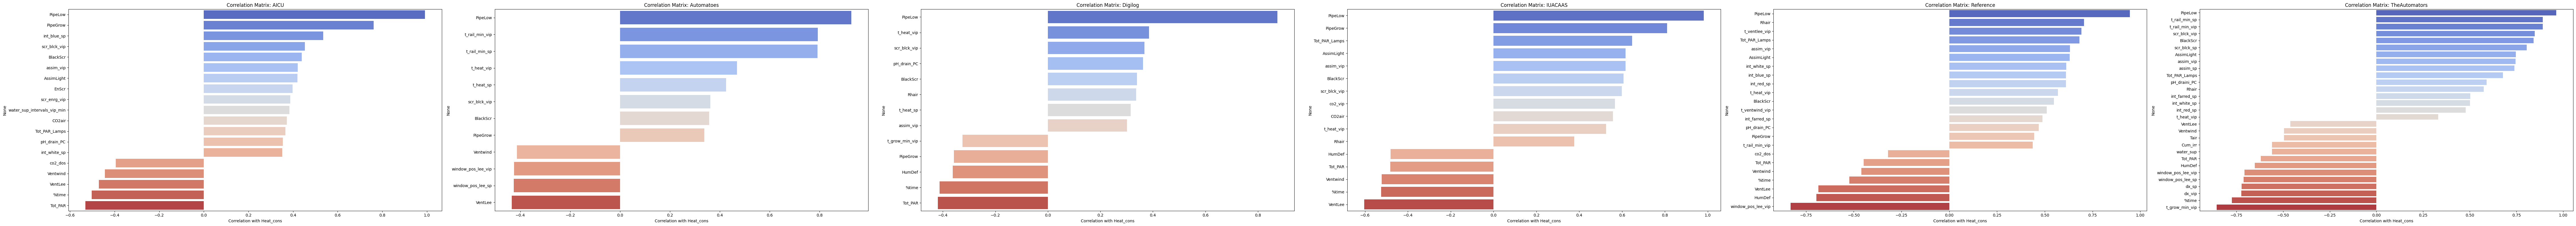

In [52]:
def plot_correlation_dict(corr_dict, figsize=(90, 8)):
    n = len(corr_dict)
    fig, axes = plt.subplots(1, n, figsize=figsize, squeeze=False)
    for idx, (key, corr_df) in enumerate(corr_dict.items()):
        # Select absolute correlations >= 0.4 with Heat_cons, drop NaNs, sort descending
        corr_heat_cons = corr_df["Heat_cons"].dropna()
        filtered = corr_heat_cons[abs(corr_heat_cons) >= 0.3].sort_values(ascending=False)
        sns.barplot(x=filtered.values, y=filtered.index, orient='h', palette='coolwarm', ax=axes[0, idx])
        axes[0, idx].set_xlabel('Correlation with Heat_cons')
        axes[0, idx].set_title(f'Correlation Matrix: {key}')
    plt.tight_layout()
    return fig, axes

# Example usage:
corr_dict = compute_correlation_dict()
fig, axes = plot_correlation_dict(corr_dict)

## Model Selection

### LSTM

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score


In [18]:
class GreenhouseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GreenhouseLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Apply dropout to the last time step
        out = self.dropout(out[:, -1, :])
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Giả sử ds là dữ liệu đã được load
sample_per_day = 288 # 5 phút 
features = ["BlackScr","PipeGrow","PipeLow","Tot_PAR","VentLee","Ventwind","t_heat_sp"]
climate = ds["Digilog"]["GreenhouseClimate.csv"][features]
resource = ds["Digilog"]["Resources.csv"]

N_days = len(climate) // sample_per_day

# Reshape input: [samples, timesteps, features]
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(climate.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (N_days, 288, 7)
y = resource["Heat_cons"].values[:N_days].reshape(-1,1) # Shape: (N_days, 1)

# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])
X_seq_scaled = np.nan_to_num(X_seq_scaled)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_scaled, y_scaled, test_size=0.2, random_state=42
)

# Chuyển sang tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [21]:
# Khởi tạo model
input_size = X_train.shape[2]  # 7 features
hidden_size = 64
num_layers = 2
output_size = 1

model = GreenhouseLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

# Huấn luyện
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Đánh giá trên tập validation
    model.eval()
    with torch.no_grad():
        test_X, test_y = X_test_tensor.to(device), y_test_tensor.to(device)
        test_outputs = model(test_X)
        test_loss = criterion(test_outputs, test_y)
        
        # Convert to numpy for metrics calculation
        predictions = test_outputs.cpu().numpy()
        actuals = test_y.cpu().numpy()
        
        # Inverse transform if you scaled your data
        if scaler_y is not None:
            predictions = scaler_y.inverse_transform(predictions)
            actuals = scaler_y.inverse_transform(actuals)
        
        # Calculate metrics
        rmse = np.sqrt(np.mean((predictions - actuals)**2))
        r2 = r2_score(actuals, predictions)
    
    scheduler.step(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Test Loss: {test_loss.item():.4f}, '
          f'Test RMSE: {rmse:.4f}, '
          f'Test R²: {r2:.4f}')

Epoch [1/100], Train Loss: 1.0655, Test Loss: 0.4855, Test RMSE: 0.4340, Test R²: 0.0386
Epoch [2/100], Train Loss: 1.2882, Test Loss: 0.4535, Test RMSE: 0.4194, Test R²: 0.1020
Epoch [3/100], Train Loss: 0.9961, Test Loss: 0.4056, Test RMSE: 0.3966, Test R²: 0.1969
Epoch [4/100], Train Loss: 0.9498, Test Loss: 0.3000, Test RMSE: 0.3411, Test R²: 0.4059
Epoch [5/100], Train Loss: 0.7581, Test Loss: 0.2472, Test RMSE: 0.3096, Test R²: 0.5105
Epoch [6/100], Train Loss: 1.0277, Test Loss: 0.1992, Test RMSE: 0.2780, Test R²: 0.6055
Epoch [7/100], Train Loss: 0.6619, Test Loss: 0.2266, Test RMSE: 0.2965, Test R²: 0.5513
Epoch [8/100], Train Loss: 0.6115, Test Loss: 0.2182, Test RMSE: 0.2910, Test R²: 0.5678
Epoch [9/100], Train Loss: 0.5988, Test Loss: 0.2061, Test RMSE: 0.2827, Test R²: 0.5919
Epoch [10/100], Train Loss: 0.5871, Test Loss: 0.2094, Test RMSE: 0.2850, Test R²: 0.5854
Epoch [11/100], Train Loss: 0.5541, Test Loss: 0.1739, Test RMSE: 0.2597, Test R²: 0.6556
Epoch [12/100], Tra

Test RMSE: 0.31, Test R²: 0.50


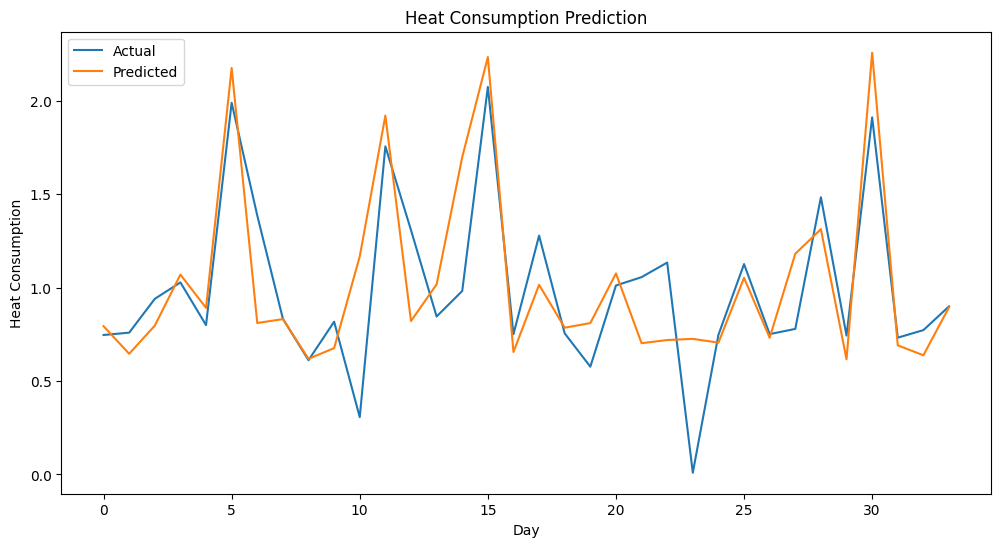

In [22]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    test_X, test_y = X_test_tensor.to(device), y_test_tensor.to(device)
    predictions = model(test_X)
    
    # Chuyển về scale gốc
    predictions = scaler_y.inverse_transform(predictions.cpu().numpy())
    actuals = scaler_y.inverse_transform(test_y.cpu().numpy())

# Tính RMSE
rmse = np.sqrt(np.mean((predictions - actuals)**2))
r2 = r2_score(actuals, predictions)
print(f'Test RMSE: {rmse:.2f}'
      f', Test R²: {r2:.2f}')

# Visualize kết quả
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Heat Consumption Prediction')
plt.xlabel('Day')
plt.ylabel('Heat Consumption')
plt.show()